<a href="https://colab.research.google.com/github/Sergeichik/MLDM-2023/blob/main/06-model-evaluation/QualityMetrics_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [2]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [3]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [4]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.9400000000000001


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

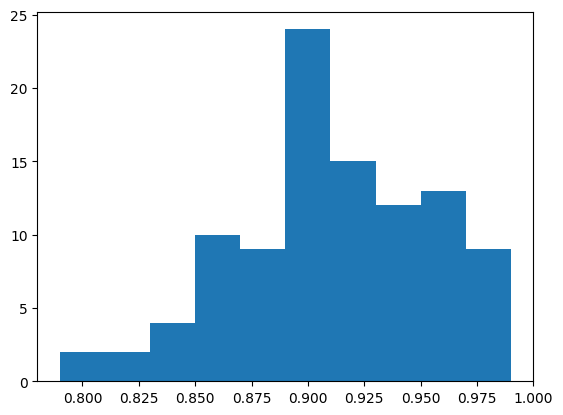

In [5]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 1 (3 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

**Answer:** The dataset should be split to test and train prior to the validation itself. And for the test sample we must use *cross_val_predict* method to estimate the cv output.

In [7]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0)
# Feature selection:
X_train_best = FeatureSelector(num_features_best).fit_transform(X_train, y_train)
X_test_best = FeatureSelector(num_features_best).fit_transform(X_test, y_test)
# Simple classification model
model = LinearSVC()
# Estimatin accuracy using cross-validation:
#cv_score = cross_val_score(model, X_train_best, y_train, scoring='accuracy', cv=10, n_jobs=-1).mean()
cv_score = cross_val_predict(model, X_test_best, y_test, cv=10).mean()
print(f"CV score is {cv_score}")

CV score is 0.55


Text(0.5, 1.0, 'Accuracy comparison\n\n')

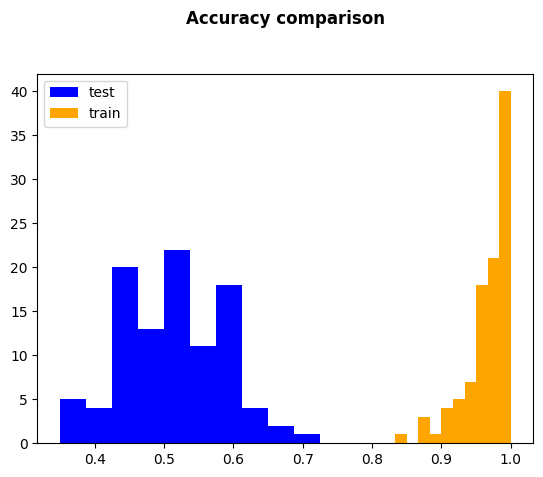

In [8]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
# Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.4, random_state=0)
  # Feature selection:
  X_train_best = FeatureSelector(num_features_best).fit_transform(X_train, y_train)
  X_test_best = FeatureSelector(num_features_best).fit_transform(X_test, y_test)
  # Simple classification model
  model = LinearSVC()
  return cross_val_predict(model, X_test_best, y_test, cv=10).mean(), cross_val_score(model, X_train_best, y_train, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment()[0] for _ in range(100)]
plt.hist(results, bins=10, label = 'test', color = 'blue');
results1 = [experiment()[1] for _ in range(100)]
plt.hist(results1, bins=10, label = 'train', color = 'orange');
plt.legend()
plt.title('Accuracy comparison\n\n',
          fontweight = "bold")

## Task 2 (3 points)

Let's come back to Task 3 of Data Handling HW.
Build a model with KNeighborsClassifier to get a higher accuracy on 5-fold Cross Validation than you achieve using your previosly fitted model (you can just copy the params from the previous notebook).

Use `sklearn.model_selection.GridSearchCV` to find best parameters.  You may check the parameters'  description as follows:
``` python
help(KNeighborsClassifier)
```

In [9]:
!wget https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv

--2023-10-24 18:17:54--  https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  58.89K  --.-KB/s    in 0.01s   

2023-10-24 18:17:54 (4.44 MB/s) - ‘train.csv’ saved [60302/60302]



In [10]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

data = pd.read_csv("train.csv", index_col='PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
def feature_selection_and_preprocessing(dataset):
  # <YOUR CODE>
  # E.g.:
  features = dataset[["Pclass", "Parch"]].copy()
  features["Pclass"] /=features["Pclass"].mean()
  return features


k_range = list(range(1, 400))
param_grid = {'leaf_size':k_range}

gscvleaf = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

# Validation code for grid search
data = pd.read_csv("train.csv", index_col='PassengerId')
data_train = data.iloc[:-100]
data_test = data.iloc[-100:]

#leaf_size
grid_search_leaf = gscvleaf.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
)
leaf_size_best = grid_search_leaf.best_params_.values().mapping['leaf_size']
print(leaf_size_best)

#n_neighbors
k_range = list(range(1, 400))
param_grid = {'n_neighbors':k_range}

gscvneighbors = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

data = pd.read_csv("train.csv", index_col='PassengerId')
data_train = data.iloc[:-100]
data_test = data.iloc[-100:]

grid_search_neighbors = gscvneighbors.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
)
neighbors_best = grid_search_neighbors.best_params_.values().mapping['n_neighbors']
print(neighbors_best)

#p
k_range = [1.0, 1.5, 2.0, 2.5, 3.0]
param_grid = {'p':k_range}

gscvp = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

data = pd.read_csv("train.csv", index_col='PassengerId')
data_train = data.iloc[:-100]
data_test = data.iloc[-100:]

grid_search_p = gscvp.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
)
p_best = grid_search_p.best_params_.values().mapping['p']
print(p_best)

#knn
model = KNeighborsClassifier(
    n_neighbors=neighbors_best,
    leaf_size=leaf_size_best,
    p = p_best
)


# Validation code (do not touch)
data = pd.read_csv("train.csv", index_col='PassengerId')
data_train = data.iloc[:-100]
data_test = data.iloc[-100:]


model.fit(
    feature_selection_and_preprocessing(
        data_train.drop('Survived', axis=1)
    ),
    data_train['Survived']
)

test_predictions = model.predict(
    feature_selection_and_preprocessing(
        data_test.drop('Survived', axis=1)
    )
)
print("Test accuracy:", accuracy_score(
    data_test['Survived'],
    test_predictions
))

159
36
1.0
Test accuracy: 0.77
